# FiftyOne Analysis

This notebook will load the dragons dataset into FiftyOne, store model predictions on the FiftyOne dataset, and explore the performance of the model to find areas of improvement.


Recap:

This notebook picks up after having run `finetune_detr.ipynb` and saved the trained checkpoint of `detr_resnet50` under `/path/to/detr/output/checkpoint.pth`.


### Load the ground truth dataset

We begin by loading the dataset with ground truth object detections into FiftyOne so we can visualize the data.

In [ ]:
!pip install fiftyone

In [2]:
import fiftyone as fo

In [3]:
fo.__version__

'0.14.2'

In [4]:
import os

In [5]:
# Should lead to a directory with a train and val folder as well as an annotations folder
dataset_dir = "/path/to/dragon_data"

In [6]:
dataset_name = "dragons"

In [7]:
dataset = fo.load_dataset(dataset_name)

In [6]:
# Reload the dataset if it was persistent
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

Load the dataset which is stored in COCO format.

In [7]:
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path= os.path.join(dataset_dir, "train"),
    labels_path= os.path.join(dataset_dir, "annotations/train.json"),
    name=dataset_name,
    tags="train",
)

 100% |███████████████████| 98/98 [187.2ms elapsed, 0s remaining, 523.5 samples/s]     


In [8]:
dataset.add_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path= os.path.join(dataset_dir, "val"),
    labels_path= os.path.join(dataset_dir, "annotations/val.json"),
    tags="val",
)

 100% |███████████████████| 10/10 [26.4ms elapsed, 0s remaining, 378.7 samples/s]    


['61a50da1f31f7843162e276b',
 '61a50da1f31f7843162e276f',
 '61a50da1f31f7843162e2770',
 '61a50da1f31f7843162e2777',
 '61a50da1f31f7843162e2778',
 '61a50da1f31f7843162e2779',
 '61a50da1f31f7843162e277a',
 '61a50da1f31f7843162e2782',
 '61a50da1f31f7843162e2783',
 '61a50da1f31f7843162e2784']

In [9]:
print(dataset)

Name:        dragons
Media type:  image
Num samples: 108
Persistent:  False
Tags:        ['train', 'val']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


Launch the FiftyOne App in the output cell of the notebook and explore the dataset.


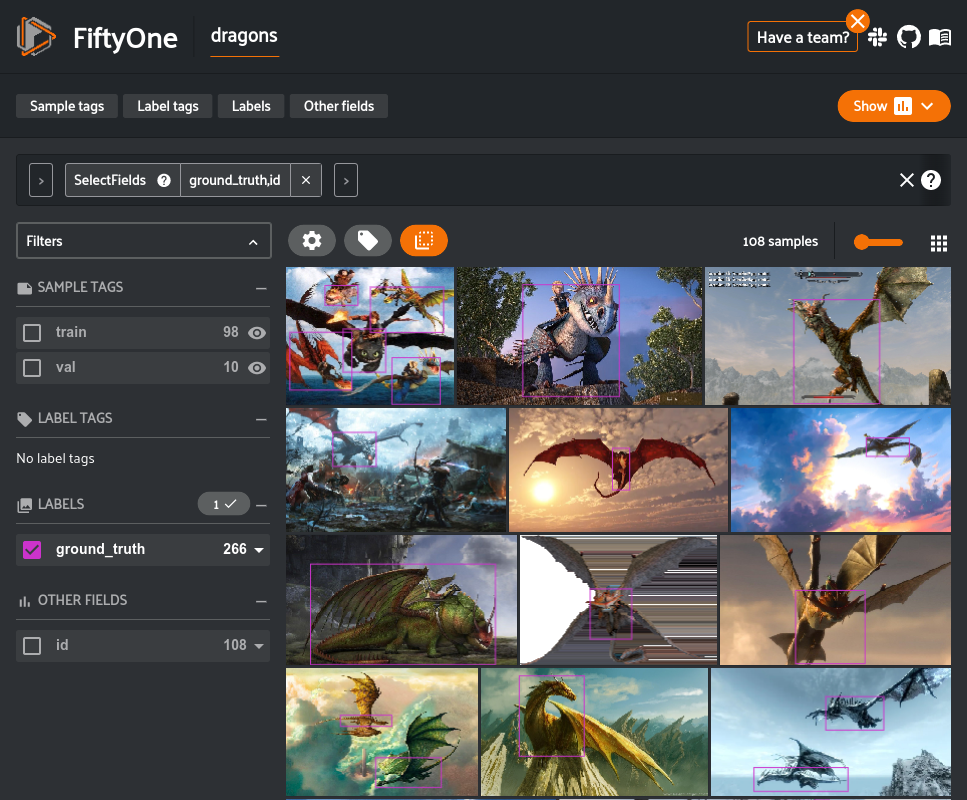

In [22]:
session = fo.launch_app(dataset)

In [23]:
session.freeze()

### Add model predictions

In this section, we use the model that we trained previously and generate predictions on every sample in our dataset.

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.10.0 True


In [ ]:
detr_dir = "/path/to/detr"

In [11]:
num_classes = 2

model = torch.hub.load('facebookresearch/detr',
                       'detr_resnet50',
                       pretrained=False,
                       num_classes=num_classes)

checkpoint = torch.load(os.path.join(detr_path, 'outputs/checkpoint.pth'),
                        map_location='cpu')

model.load_state_dict(checkpoint['model'],
                      strict=False)

model.eval()

Using cache found in /home/erich/.cache/torch/hub/facebookresearch_detr_main


DETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_f

In [12]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [15]:
from PIL import Image

classes = ["dragon"]

for sample in dataset.iter_samples(progress=True):
    image = Image.open(sample.filepath)
    if image.mode != "RGB":
        image = image.convert("RGB")
    
    # Mean-std normalize the input image (batch-size: 1)
    image = transform(image).unsqueeze(0)

    # Perform inference
    preds = model(image)
    
    scores = preds["pred_logits"].softmax(-1)[0, :, :-1]
    
    keep_thresh = 0.2
    keep = scores.max(-1).values > keep_thresh
    
    scores = scores[keep].cpu().detach().numpy()
    boxes = preds["pred_boxes"][0, keep].cpu().detach().numpy()
    
    # Convert detections to FiftyOne format
    detections = [] 
    for score, box in zip(scores, boxes):
        # Output boxes in [center-x, center-y, width, height]
        # Convert to [top-left-x, top-left-y, width, height]
        cx, cy, w, h = box
        formatted_box = [cx - 0.5 * w, cy - 0.5 * h, w, h]
        
        label_ind = score.argmax()
        label = classes[label_ind]
        confidence = score[label_ind]
        
        detections.append(
            fo.Detection(
                label=label,
                bounding_box=formatted_box,
                confidence=confidence,
            )
        )

    # Save predictions to dataset
    sample["predictions"] = fo.Detections(detections=detections)
    sample.save()

 100% |█████████████████| 108/108 [55.2s elapsed, 0s remaining, 2.1 samples/s]      



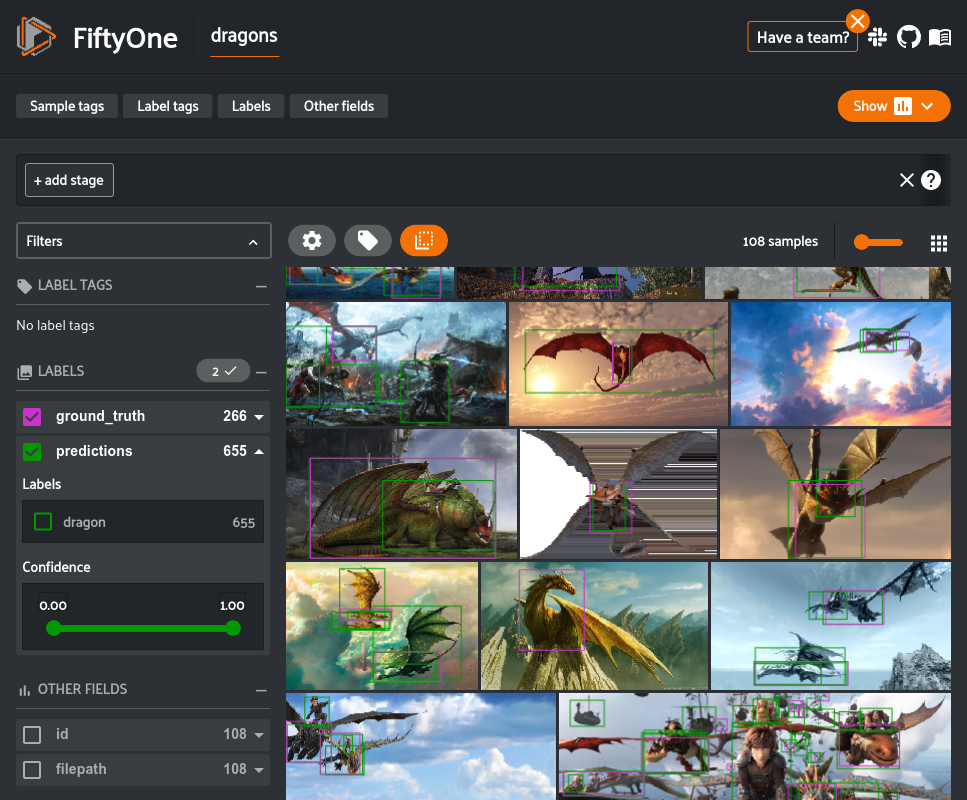

In [16]:
session = fo.launch_app(dataset)

In [10]:
session.freeze()

### Analyze model results

First, we should find an appropriate confidence threshold to limit the predictions in the dataset. We already thresholded the detections to an arbitrary value when loading them, but now let's look at the results and make a more informed decision.

One way to find a threshold value for detection confidence is to calculate the number of true and false positives that exist currently and find the point at which there are an equal number of both.

We will use FiftyOne's [`evalute_detections()`](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections) method to use COCO-style object detection evaluation to compute if each ground truth and prediction is either a true positive, false positive, or false negative.

In [63]:
eval_key = "full_dataset_eval"

In [30]:
results = dataset.evaluate_detections(
    "predictions", 
    gt_field="ground_truth", 
    eval_key=eval_key, 
)

Evaluating detections...
 100% |█████████████████| 108/108 [532.6ms elapsed, 0s remaining, 202.8 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 108/108 [898.6ms elapsed, 0s remaining, 120.2 samples/s]      


Now that the TP/FP/FN information is stored on the sample in the dataset, we can create two views into our dataset by using the [powerful querying capabilities of FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/using_views.html). 

In [8]:
from fiftyone import ViewField as F

In [ ]:
tp_view = dataset.filter_labels("predictions", F(eval_key) == "tp")
fp_view = dataset.filter_labels("predictions", F(eval_key) == "fp")

FiftyOne provides a set of [aggregation functions](https://voxel51.com/docs/fiftyone/user_guide/using_aggregations.html) on datasets that allow you to efficiently gather dataset-wide information about your samples. One example of these aggregations is [`histogram_values`()](https://voxel51.com/docs/fiftyone/user_guide/using_aggregations.html#histogram-values) which will return the counts and edges of all of the values in a specified field of your dataset that can easily plotted in a histogram.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
def plot_hist(counts, edges):
    counts = np.asarray(counts)
    edges = np.asarray(edges)
    left_edges = edges[:-1]
    widths = edges[1:] - edges[:-1]
    plt.bar(left_edges, counts, width=widths, align="edge")

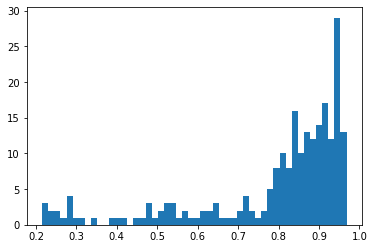

In [71]:
tp_counts, tp_edges, other = tp_view.histogram_values("predictions.detections.confidence", bins=50)
plot_hist(counts, edges)

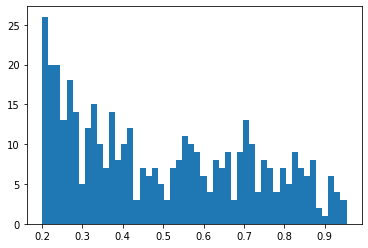

In [73]:
fp_counts, fp_edges, other = fp_view.histogram_values("predictions.detections.confidence", bins=50)
plot_hist(fp_counts, fp_edges)

Lets integrate over this histogram starting at the highest confidence to find the confidence at which the number of true positives equals the number of false positives.

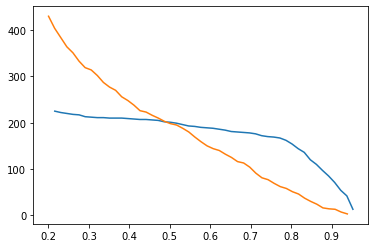

In [74]:
plt.plot(tp_edges[:-1][::-1], np.cumsum(tp_counts[::-1]))
plt.plot(fp_edges[:-1][::-1], np.cumsum(fp_counts[::-1]))
plt.show()

Based on this graph, we should set our confidence threshold to around 0.5. Lets visualize the dataset in the FiftyOne App to visually check how well this confidence threshold works for this problem.


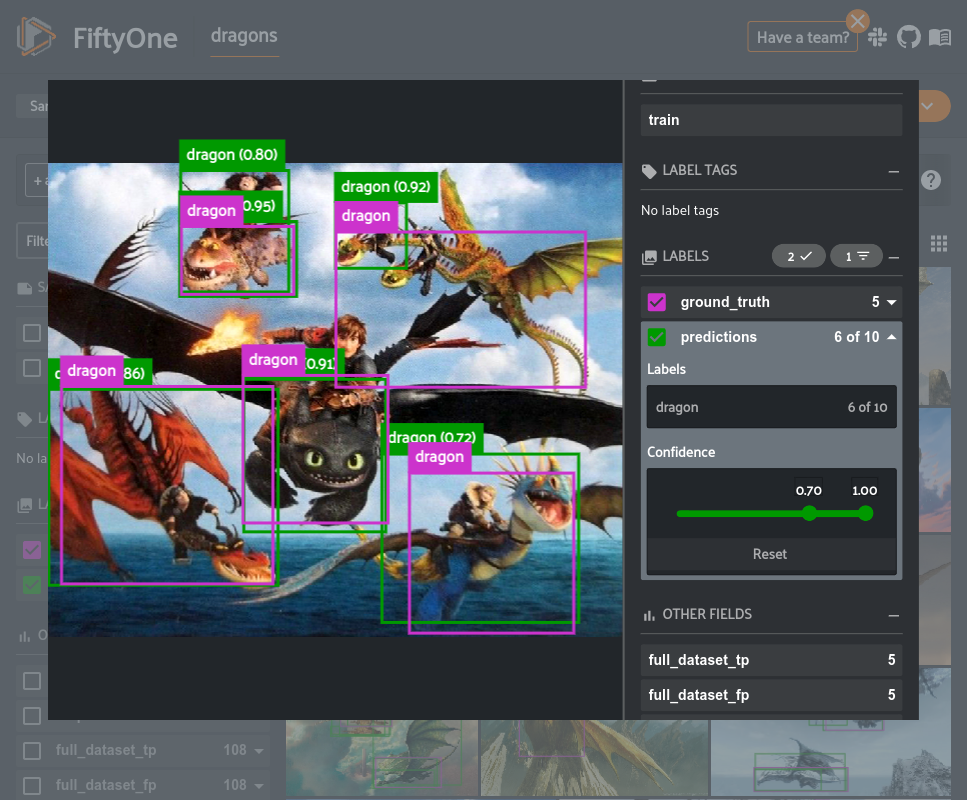

In [41]:
session.dataset = dataset

In [42]:
session.freeze()

After browsing through the samples in the dataset, a threshold of 0.5 provides enough flexibility to detect many of the dragons in the dataset without too many false positives.

Now, let's create a view programmatically using this confidence threshold and reevaluate the model predictions, computing COCO-style mAP as well this time.

In [13]:
conf_thresh = 0.5
high_conf_view = dataset.filter_labels("predictions", F("confidence") > conf_thresh)


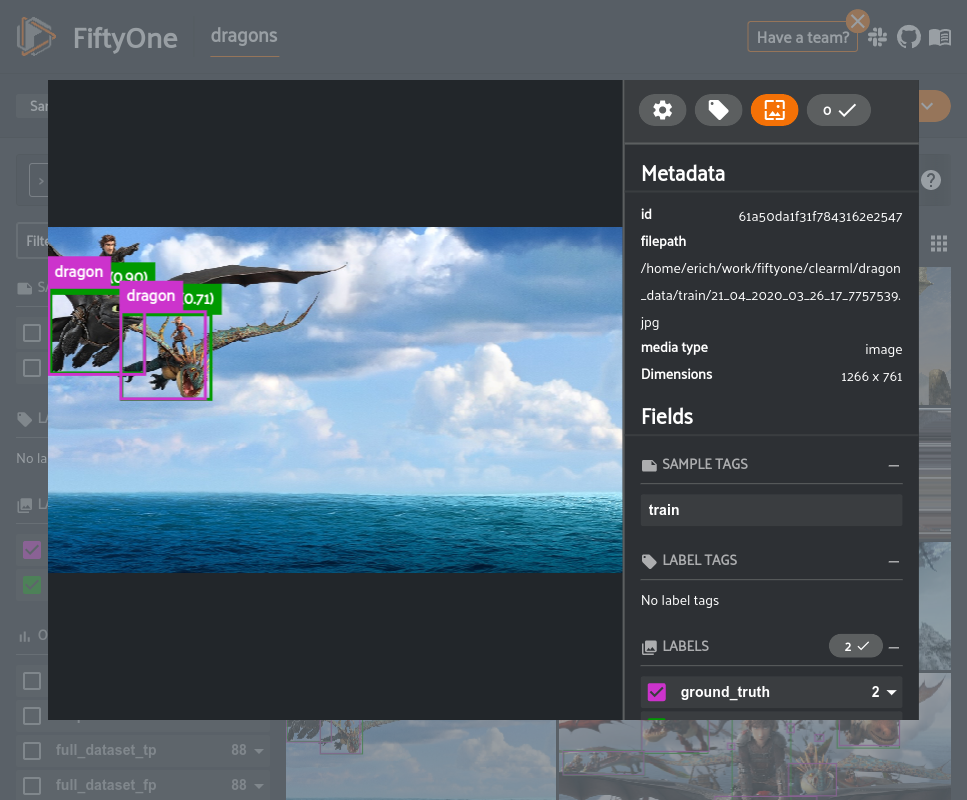

In [44]:
session.view = high_conf_view

In [45]:
session.freeze()

In [15]:
eval_key = "eval"

In [76]:
results = high_conf_view.evaluate_detections(
    "predictions", 
    gt_field="ground_truth", 
    eval_key=eval_key, 
    compute_mAP=True,
)

Evaluating detections...
 100% |█████████████████| 101/101 [1.1s elapsed, 0s remaining, 94.7 samples/s]          
Performing IoU sweep...
 100% |█████████████████| 101/101 [660.0ms elapsed, 0s remaining, 153.0 samples/s]      


In [78]:
print(results.mAP())

0.3416714132507098


Given the size of the dataset, this model is performing relatively well. However, there seems to still be a lot of room for improvement.

### Analyze results

One of the primary uses of FiftyOne is the ability to easily query and explore your dataset and model predictions for any question that comes to mind. For example, lets take a look at all of the predictions that were false positives but with a high confidence, indicating that the model was fairly certain about it's detection but was incorrect. These types of examples usually indicate an error in the ground truth.

In [16]:
high_conf_fp = high_conf_view.filter_labels("predictions", (F(eval_key) == "fp") & (F("confidence") > 0.9))


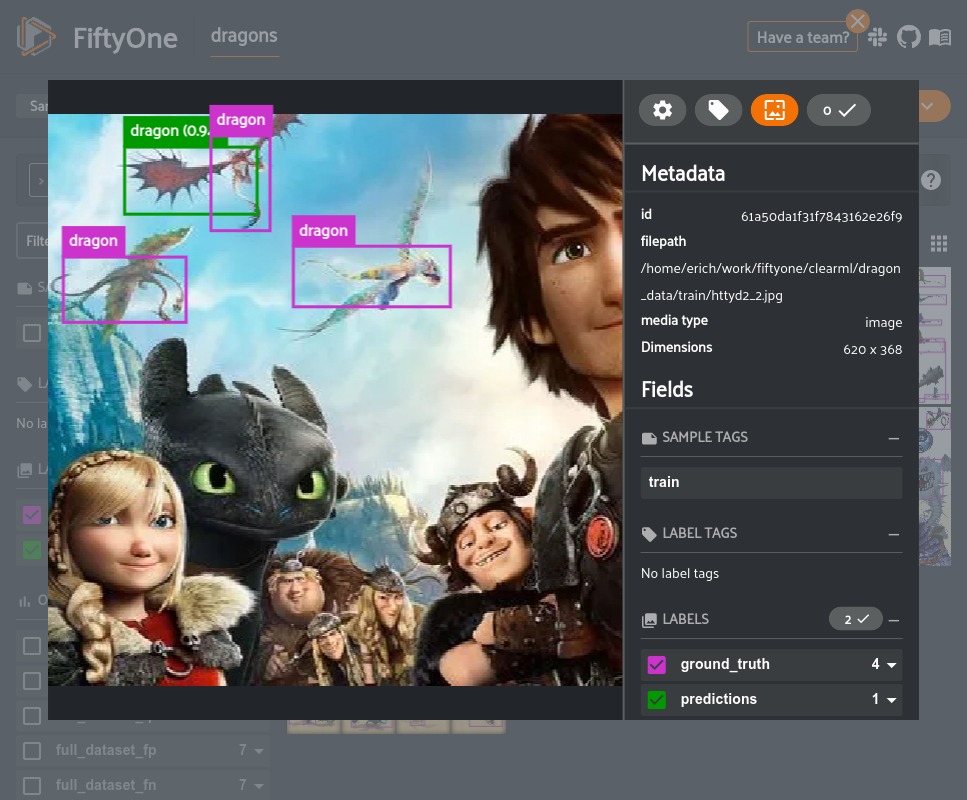

In [80]:
session.view = high_conf_fp

In [81]:
session.freeze()

From the example above, it seems that one issue with our dataset is that we did not consistently annotate the wings of dragons. The model relatively accurately detected the dragon, but also included the wing which resulted in an IoU below the threshold used for evaluation (IoU=0.5). This detection would not necessarily be incorrect, though, so we may want to take a pass over the dataset to ensure dragon wings are consistently annotated.

Now, let's take a look at the false negatives in the dataset, where the model did not detect a ground truth object.

In [82]:
fn_view = high_conf_view.filter_labels("ground_truth", F(eval_key) == "fn")


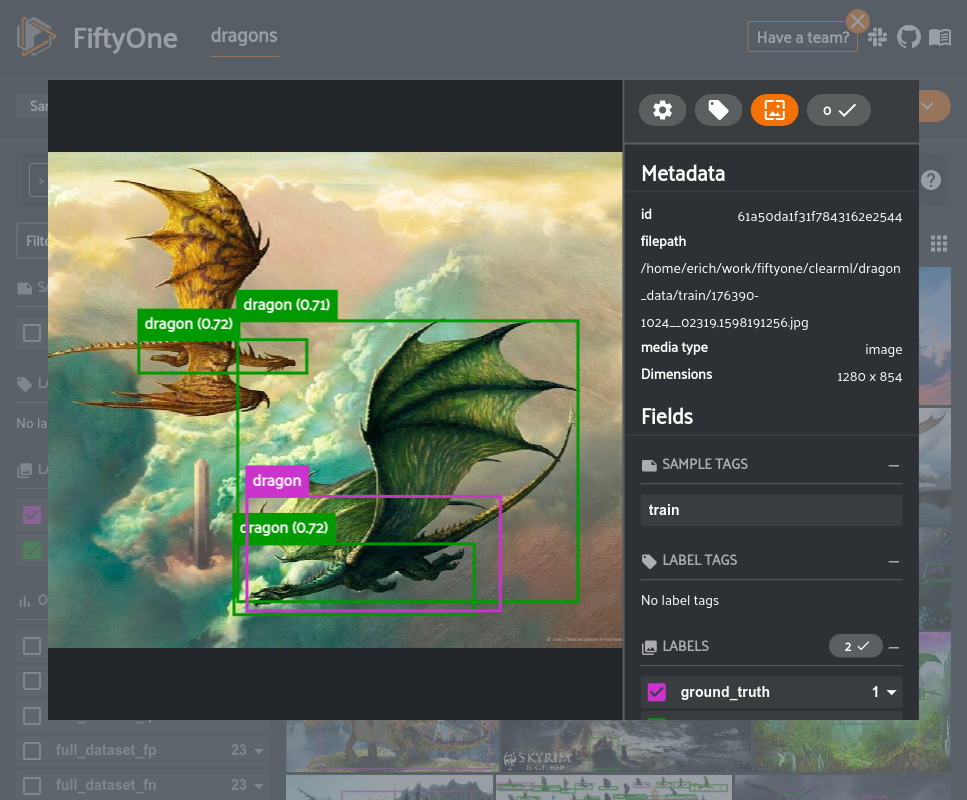

In [83]:
session.view = fn_view

In [84]:
session.freeze()

From the example above, we see another issue of the model incorrectly localizing the bounding box, even though it did detect the presence of a dragon. The comment about reannotating the dataset to include dragon wings still holds, however, it would also be useful to add additional training data to allow the model to learn to more accurately localize the boxes.


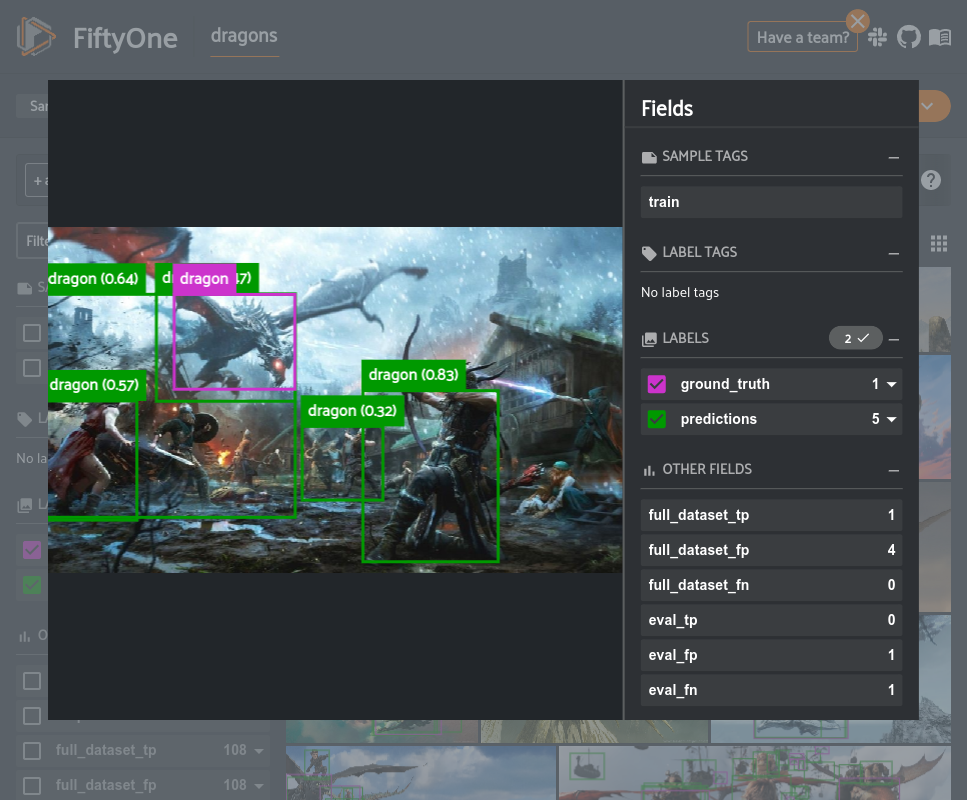

In [53]:
session.dataset = dataset

In [54]:
session.freeze()

In the example above, we see that another issue is that the model is frequently detection non-dragon objects as dragons. The majority of the samples in this dataset contain only one or a few dragons isolated from other objects. Thus, the model seems to be learning to just detect all of the focal objects in the scene.

The best way to resolve this would be to add more scenes with multiple types of objects to the dataset as well as expanding the classes to other object types so that the model is able to learn to better differentiate between dragons and other objects.

### Train vs Validation split

You may have noticed that all of the examples above have included samples from both the training and validation splits. We can also create views to evaluate the training and validation samples separately.

In [17]:
train_view = high_conf_view.match_tags("train")
val_view = high_conf_view.match_tags("val")

In [86]:
train_results = train_view.evaluate_detections(
    "predictions", 
    gt_field="ground_truth", 
    compute_mAP=True,
)
val_results = val_view.evaluate_detections(
    "predictions", 
    gt_field="ground_truth", 
    compute_mAP=True,
)

Evaluating detections...
 100% |███████████████████| 93/93 [615.8ms elapsed, 0s remaining, 151.0 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 93/93 [672.7ms elapsed, 0s remaining, 138.3 samples/s]      
Evaluating detections...
 100% |█████████████████████| 8/8 [18.8ms elapsed, 0s remaining, 425.0 samples/s] 
Performing IoU sweep...
 100% |█████████████████████| 8/8 [23.1ms elapsed, 0s remaining, 346.2 samples/s] 


In [87]:
print("Train mAP: ", train_results.mAP())
print("Val mAP: ", val_results.mAP())

Train mAP:  0.34209299981356495
Val mAP:  0.43994970925664


Given the similarity in performance between the train and validation splits, it appears there may be room for further improvement in model performance by continuing to train the model for a few more epochs.

This also indicates that the analysis that we have performed on the combined train and validation splits seems to hold for unseen data.


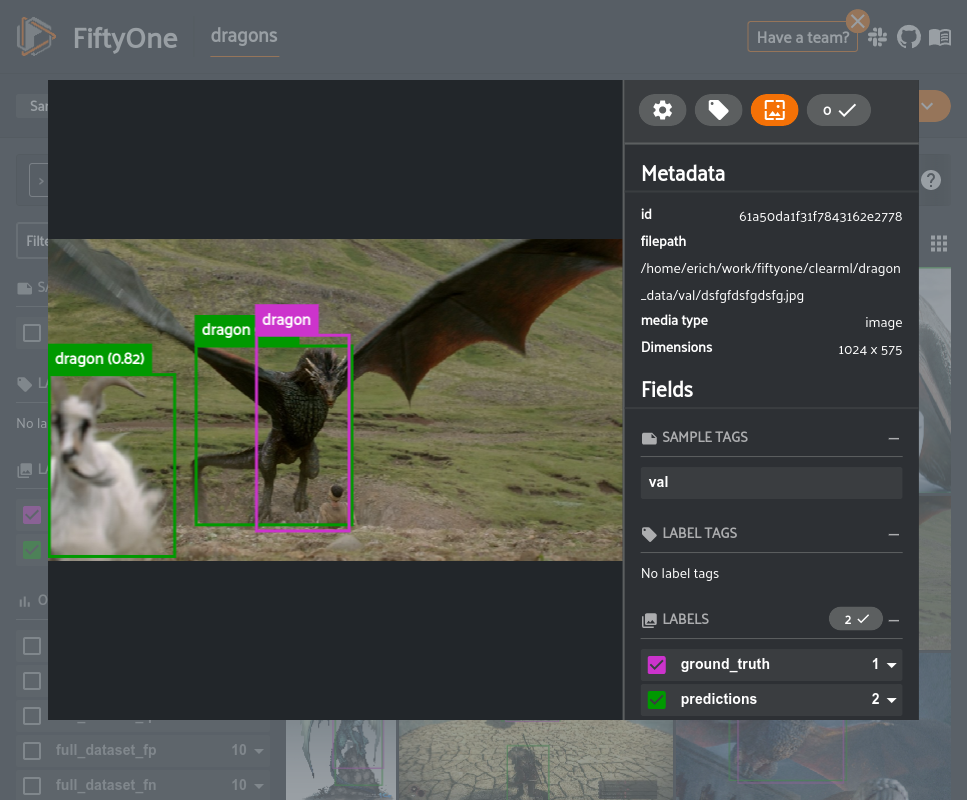

In [19]:
session = fo.launch_app(view=val_view)

In [20]:
session.freeze()

### Next steps

Based on the observations in the previous sections, we can take these steps to develop a high quality dataset and high performing model.

**Include dragon wings in the bounding box annotations**

FiftyOne provides support for annotation through integrations with top annotation tools. For example, we can reannotate the dataset as easily as:

In [ ]:
anno_key = "dragons"

dataset.annotate(
    anno_key,
    label_field="ground_truth",
    backend="cvat",
    launch_editor=True,
)

# Reannotate samples in CVAT

dataset.load_annotations(anno_key)

**Add more samples to the dataset**

As we have noted above, adding more crowded scenes as well as images with other types of objects can result in a model that is better equipped to detect dragons.

FiftyOne provides a dataset zoo with numerous popular datasets that can be used to supplement your datasets. For example, we may want to add some examples of lizards and dinosaurs from the [Open Images dataset](https://voxel51.com/docs/fiftyone/integrations/open_images.html):

In [ ]:
import fiftyone.zoo as foz

new_data = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    classes=["Lizard", "Dinosaur"],
    max_samples=100,
)

We leave the implementation and results of these next steps for follow-up post.